In [1]:
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from src.make_dataset import process_image, parse_and_save_dir

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
def load_dataset(image_dir):
    data_list = []
    fn_list = [x for x in os.listdir(image_dir) if ".tif" in x]
    for fn in fn_list:
        input_file = image_dir + fn
        data = process_image(input_file)
        data_list.append(data)
    return data_list

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)

    # calculate sum squared difference between means
    ssdiff  = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean  = sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
        
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

def expand_channels(data_list):
    lx, ly, _ = data_list[0].shape
    new_data = []
    for data in data_list:
        expanded_data = np.zeros((lx, ly, 3))
        expanded_data[:,:,0] = data[:,:,0]
        data_fft = np.fft.fftshift(np.fft.fft2(data[:,:,0]))
        rfft = data_fft.real 
        ifft = data_fft.imag
        power = rfft*rfft + ifft*ifft
        #expanded_data[:,:,1] = np.log10(power)
        expanded_data[:,:,1] = data[:,:,0]
        expanded_data[:,:,2] = data[:,:,0]
        new_data.append(expanded_data) 
    return np.array(new_data)

In [3]:
gaussian   = 0.1 

identifier = "20240426_DATA_brightfield_mixed_edit"


parent_dir = "/mnt/d/cycle_gan/"
exp_dir_raw = parent_dir + "data/exp/brightfield_mixed_edit_real/"
sim_dir_raw = parent_dir + "data/sim/brightfield_mixed_synth/"

exp_dir = exp_dir_raw[:-1] + "_256_slices/"
sim_dir = sim_dir_raw[:-1] + "_gauss_{}_256_slices/".format(gaussian)

In [4]:
image_exp = preprocess_input(expand_channels(load_dataset(exp_dir)))
fid_scores = []
for i in range(41):
    ganned_dir = parent_dir + "data/GAN/exp/{}_CKPT_{}/".format(identifier, i)
    image_gan = preprocess_input(expand_channels(load_dataset(ganned_dir)))
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(256,256,3))
    fid = calculate_fid(model, image_exp, image_gan)
    print('       idx: {}     FID (exp, gan): {:.3f}'.format(i, fid))
    fid_scores.append(fid)

14/14 [==============================] - 1s 36ms/step
       idx: 0     FID (exp, gan): 2.223
14/14 [==============================] - 0s 19ms/step
       idx: 1     FID (exp, gan): 2.371
14/14 [==============================] - 0s 21ms/step
       idx: 2     FID (exp, gan): 2.047
14/14 [==============================] - 0s 19ms/step
       idx: 3     FID (exp, gan): 1.904
14/14 [==============================] - 0s 18ms/step
       idx: 4     FID (exp, gan): 2.127
14/14 [==============================] - 0s 20ms/step
       idx: 5     FID (exp, gan): 1.962
14/14 [==============================] - 0s 19ms/step
       idx: 6     FID (exp, gan): 1.997
14/14 [==============================] - 0s 19ms/step
       idx: 7     FID (exp, gan): 2.128
14/14 [==============================] - 0s 19ms/step
       idx: 8     FID (exp, gan): 1.945
14/14 [==============================] - 0s 19ms/step
       idx: 9     FID (exp, gan): 1.876
14/14 [==============================] - 0s 21ms/step
      

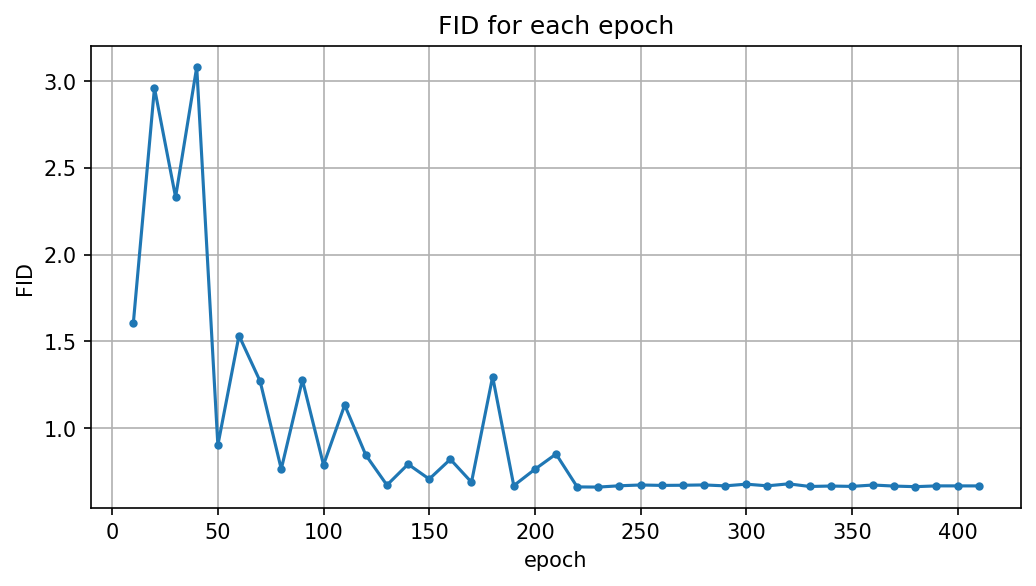

min FID:  0.6606007391284069
min FID ckpt:  22


In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8,4), dpi=150)
x = [(i+1)*10 for i in range(len(fid_scores))]
plt.plot(x, fid_scores, '.-')
plt.xlabel("epoch")
plt.ylabel("FID")
plt.title("FID for each epoch")
plt.grid()
plt.show()
print("min FID: ", min(fid_scores))
print("min FID ckpt: ", np.argmin(fid_scores))
